In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils.enhance import img_weighted
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2024-04-25 16:40:12.142323: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Split dataset

In [2]:
df = pd.read_csv("brain_tumor_dataset/annotations.csv")

# split train test
# use stratify for imbalanced yes, no 
train_df, test_df = train_test_split(df, test_size=0.2, random_state=777, stratify=df.labels)

# split train validation 
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=777, stratify=train_df.labels)

print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)


(161, 2)
(41, 2)
(51, 2)


In [3]:
train_df

,filepaths,labels
36,brain_tumor_dataset/no/No17.jpg,no
214,brain_tumor_dataset/yes/Y28.jpg,yes
77,brain_tumor_dataset/no/no 91.jpeg,no
51,brain_tumor_dataset/no/No18.jpg,no
48,brain_tumor_dataset/no/no 90.jpg,no
...,...,...
103,brain_tumor_dataset/yes/Y47.JPG,yes
191,brain_tumor_dataset/yes/Y11.jpg,yes
209,brain_tumor_dataset/yes/Y258.JPG,yes
250,brain_tumor_dataset/yes/Y62.jpg,yes


In [4]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: img_weighted(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=64,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=64,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= valid_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=64,
                                    shuffle=False
                                   )

Found 161 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.


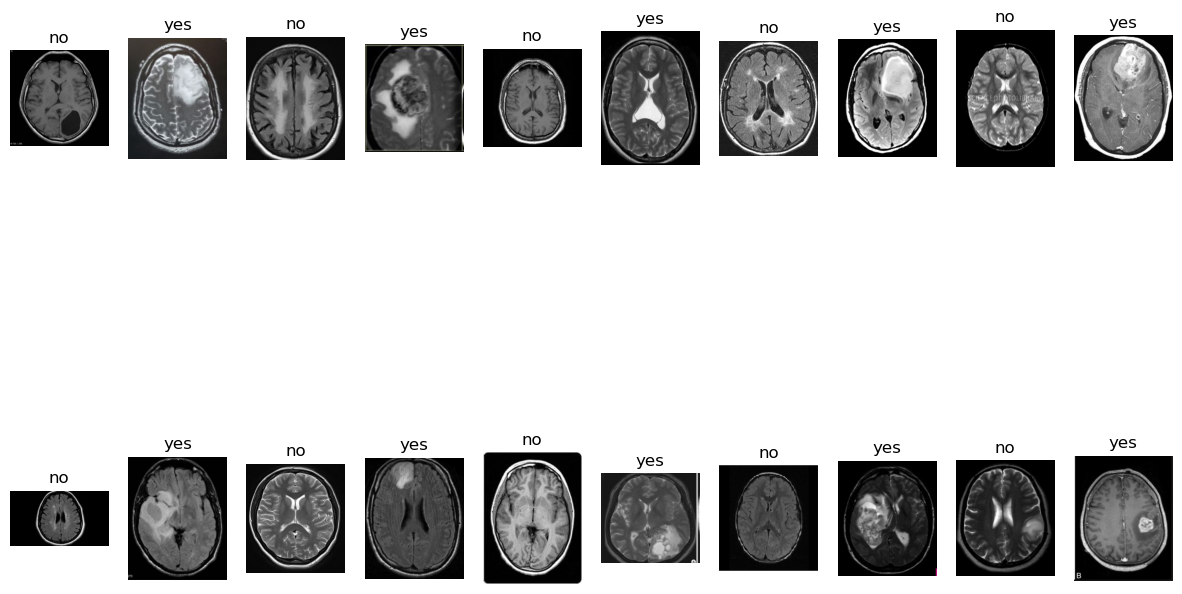

In [5]:
# Define the number of images to display from each class
num_images_per_class = 10

# Get class labels
class_labels = list(train.class_indices.keys())

# Plot images from each class
plt.figure(figsize=(15, 10))
for label in class_labels:
    # Get indices of images belonging to the current class
    indices = train_df[train_df['labels'] == label].index
    
    # Randomly sample a subset of indices if there are more than the desired number of images per class
    indices = np.random.choice(indices, min(num_images_per_class, len(indices)), replace=False)
    
    # Plot images
    for i, idx in enumerate(indices):
        plt.subplot(len(class_labels), num_images_per_class, len(class_labels)*i + class_labels.index(label) + 1)
        plt.imshow(plt.imread(train_df.loc[idx, 'filepaths']))  # Load and plot the image
        plt.title(label)
        plt.axis('off')
plt.show()

In [6]:
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception

learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max')
x = base_model.output
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=150, validation_data=val)

Epoch 1/150


/Users/sungwonlee/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 128s 33s/step - accuracy: 0.6058 - loss: 1.0274 - val_accuracy: 0.7561 - val_loss: 0.5781
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 38s/step - accuracy: 0.8010 - loss: 0.5321 - val_accuracy: 0.7317 - val_loss: 0.6386
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 92s 39s/step - accuracy: 0.9426 - loss: 0.2183 - val_accuracy: 0.8293 - val_loss: 0.3863
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 28s/step - accuracy: 0.9739 - loss: 0.0513 - val_accuracy: 0.8537 - val_loss: 0.2579
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 95s 38s/step - accuracy: 0.9969 - loss: 0.0632 - val_accuracy: 0.9268 - val_loss: 0.1872
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 93s 39s/step - accuracy: 0.9943 - loss: 0.0259 - val_accuracy: 0.9268 - val_loss: 0.1836
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 93s 29s/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.9512 - val_loss: 0.1725
Epoch 8/150
1/3 ━━━━━━━━━━━━━━━━━━━━ 27s 14s/step - accuracy: 0.9697 - loss: 0.1614